In [2]:
from astropy.io import fits
import lightkurve as lk
import exoplanet as xo
import numpy as np
import scipy as sp
import pymc3 as pm
from matplotlib import pyplot as plt

#import mytoolkit as tk

Filename: c05.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   ()      
  1  ARRAYS        1 BinTableHDU    316   3663R x 13C   [D, D, D, D, J, D, D, D, D, D, D, D, D]   
  2  PIXELS        1 BinTableHDU     19   3663R x 2C   [29D, 332D]   
  3  APERTURE MASK    1 ImageHDU        54   (7, 6)   int64   
  4  POSTAGE STAMPS    1 BinTableHDU     61   6R x 3C   [7D, 7D, 7D]   
  5  HI RES IMAGE    1 ImageHDU        54   (70, 60)   float64   


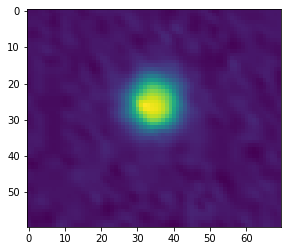

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT ************************                                                
COMMENT *     MISSION INFO     *                                                
COMMENT ************************                                                
TELESCOP= 'Kepler  '           / telescope                                      
INSTRUME= 'Kepler Photometer'  / detector type                                  
OBJECT  = 'EPIC 211924657'     / string version of target id                    
KEPLERID=            211924657 / unique Kepler target identifier                
CHANNEL =                   46 / CCD channel                                    
MODULE  =                   

In [3]:
with fits.open("c05.fits") as hdul:
    hdul.info()
    data = hdul[5].data
    plt.imshow(data, interpolation='nearest')
    plt.show()
    print(repr(hdul[0].header))

<AxesSubplot:xlabel='Time', ylabel='Flux'>

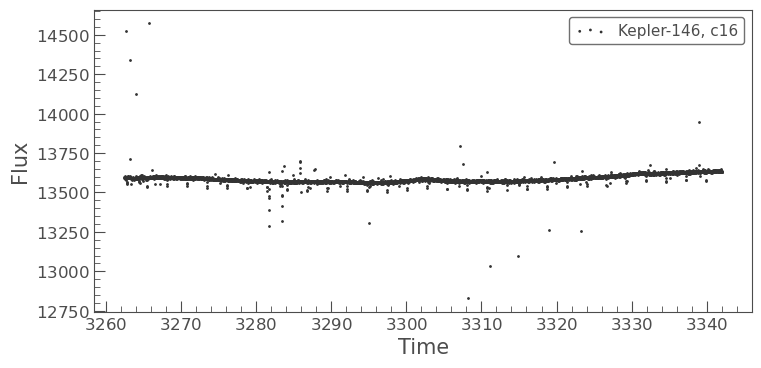

In [4]:
lc = tk.fits_to_lk('c16.fits')
lc.scatter()

<AxesSubplot:xlabel='Time', ylabel='Flux'>

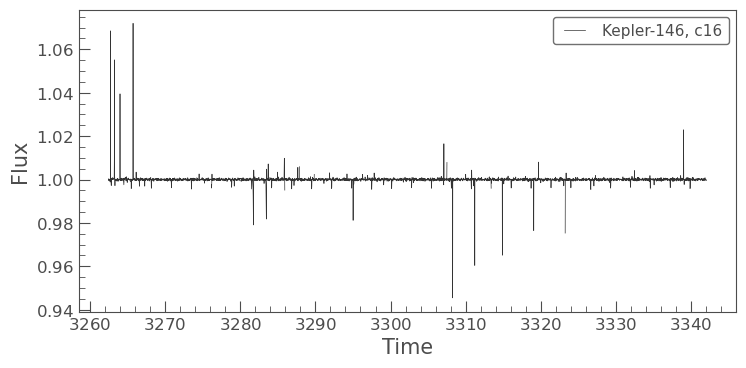

In [5]:
flat_lc, trend = lc.flatten(return_trend=True) ### Maybe try changing the windowing size??
#ax = lc.plot() 
#trend.plot(ax=ax, color='red', lw=2, label='Trend');
flat_lc.plot()

<AxesSubplot:xlabel='Time', ylabel='Flux'>

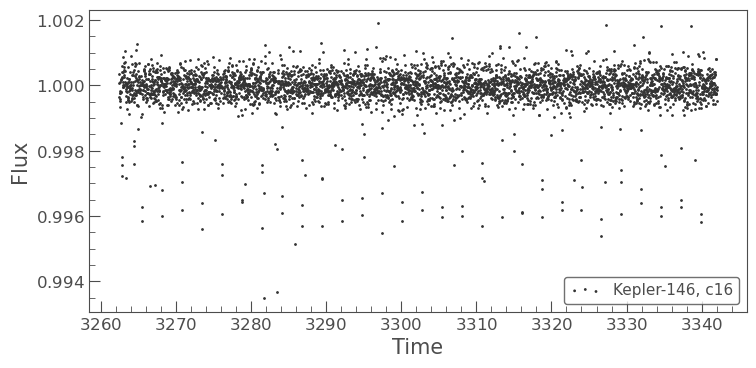

In [6]:
clean_lc = flat_lc.remove_outliers(sigma_lower=10, sigma_upper=3)
clean_lc.scatter()

Best fit period: 2.6614 d
3262.792818728968


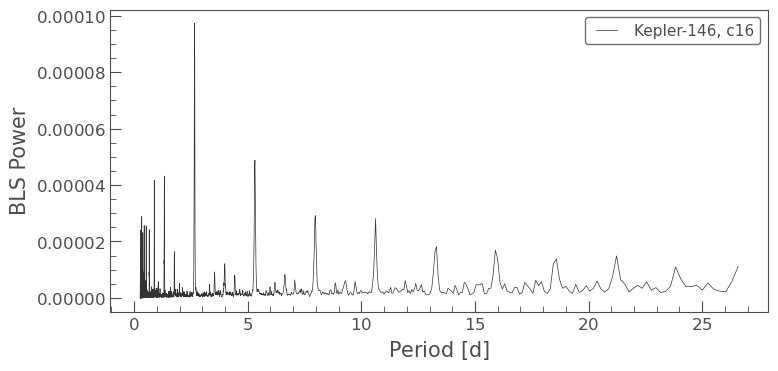

In [8]:
periodogram = clean_lc.to_periodogram(method="bls")
periodogram.plot();
best_fit_period = periodogram.period_at_max_power
print('Best fit period: {:.4f}'.format(best_fit_period))
print(periodogram.transit_time_at_max_power)

## pymc3 Model

In [7]:
import mytoolkit as tk
lc = tk.fits_to_lk('c05.fits')
clean_lc = tk.process_lightcurve(lc)
model, map_soln = tk.model_single_planet(clean_lc)

*** 59 outliers were removed in processing ***
Estimated t0 = 2308.935732210596
Estimated period = 2.645689699019684


C:\Users\porri\anaconda3\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [b, r, u, logP, t0, mean]


C:\Users\porri\anaconda3\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
C:\Users\porri\anaconda3\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])



mean = 0.9999985628100199
t0 = 2308.995201196527
period = 2.6449348903902634
u = [ 1.53612431 -0.619532  ]
r = 0.06190584310570721
b = 0.7746235232244091


C:\Users\porri\anaconda3\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 20632.437210413056 -> 21250.0223157449


##### DO EVERYTHING WITH MEAN=0 CAUSE FLOATS WILL BE MORE ACCURATE!

## Run Hamiltonian MC

In [8]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=3000,
        draws=3000,
        start=map_soln,
        cores=1,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

C:\Users\porri\anaconda3\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sequential sampling (2 chains in 1 job)
NUTS: [b, r, u, logP, t0, mean]
Sampling chain 0, 0 divergences:   0%|          | 0/6000 [00:00<?, ?it/s]C:\Users\porri\anaconda3\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sampling chain 1, 0 divergences: 100%|██████████| 6000/6000 [01:21<00:00,

In [9]:
pm.summary(trace, var_names=["period", "t0", "r", "b", "u", "mean"])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
period,2.645,0.000,2.645,2.645,0.000,0.000,5027.0,5027.0,5038.0,3452.0,1.0
t0,2308.996,0.002,2308.992,2308.999,0.000,0.000,4921.0,4915.0,4944.0,3500.0,1.0
r,0.061,0.003,0.055,0.067,0.000,0.000,3852.0,3844.0,3875.0,3528.0,1.0
b,0.764,0.039,0.688,0.832,0.001,0.001,2939.0,2939.0,3071.0,3265.0,1.0
u[0],1.512,0.361,0.827,1.988,0.007,0.005,2480.0,2480.0,2694.0,2942.0,1.0
u[1],-0.589,0.340,-0.990,0.066,0.007,0.005,2492.0,2492.0,2658.0,2894.0,1.0
mean,1.000,0.000,1.000,1.000,0.000,0.000,5103.0,5103.0,5101.0,4145.0,1.0


In [10]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["period", "r"])
truth = xo.eval_in_model([period, r], model.test_point, model=model)
_ = corner.corner(
    samples,
    truths=truth,
    labels=["period", "radius"],
)

NameError: name 'period' is not defined

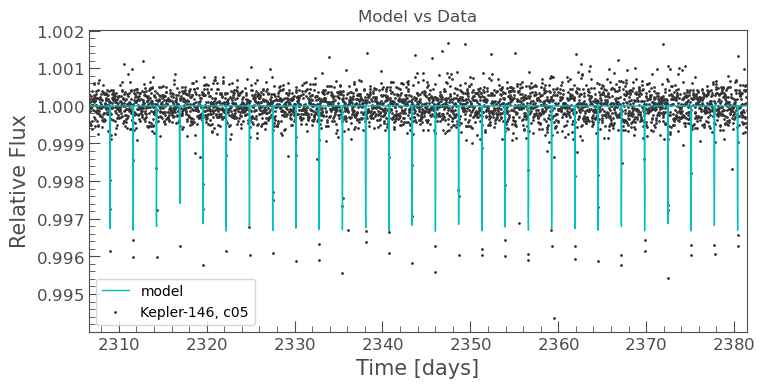

(-0.3, 0.3)

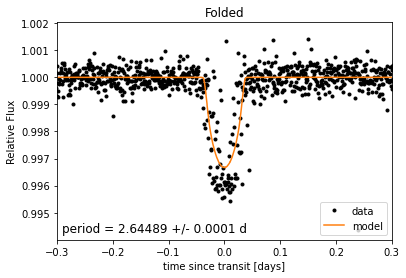

In [11]:
t = np.array(clean_lc.time, dtype='float64')
y = np.array(clean_lc.flux, dtype='float64')

# Plot the model vs data
clean_lc.scatter()
pred = trace["light_curve"]
pred = np.median(pred, axis=0)
plt.plot(t, pred, 'c',lw=1, label="model")
plt.xlim(t.min(), t.max())
plt.ylabel("Relative Flux")
plt.xlabel("Time [days]")
plt.title("Model vs Data")
plt.legend(fontsize=10)
plt.show()

plt.figure()
# Get the posterior median orbital parameters
p = np.median(trace["period"])
t0 = np.median(trace["t0"])

# Plot the folded data
x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
plt.plot(x_fold, y, ".k", label="data")

# Plot the folded model
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 0.3]
pred = trace["light_curve"][:, inds]
pred = np.median(pred, axis=0)
plt.plot(x_fold[inds], pred, color="C1", label="model")

# Annotate the plot with the planet's period
txt = "period = {0:.5f} +/- {1:.4f} d".format(
    np.mean(trace["period"][:]), np.std(trace["period"][:])
)
plt.annotate(
    txt,
    (0, 0),
    xycoords="axes fraction",
    xytext=(5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=12,
)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5 * p, 0.5 * p)
plt.xlabel("time since transit [days]")
plt.ylabel("Relative Flux")
plt.title("Folded")
plt.xlim(-0.3, 0.3)


### River Plot

C:\Users\porri\anaconda3\lib\site-packages\lightkurve\lightcurve.py:1882: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(bs, cycs, ar.T, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)


<AxesSubplot:title={'center':'Kepler-146, c05'}, xlabel='Phase', ylabel='Cycle'>

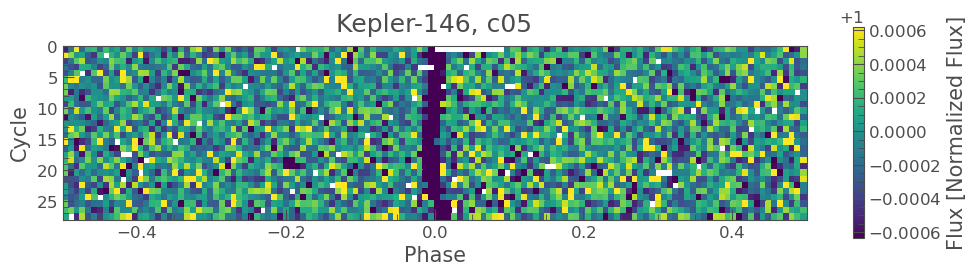

In [12]:
clean_lc.plot_river(period=p, t0=t0)